# Moving on to Clustering/Classifying Attempt 2

## What was wrong with the first attempt?

Cluster/classify step was too noisy, I wasn't confident that the pipeline as assembled would be able to accurately break text into groups semantically.

## What am I trying now?

I'm trying a different, slightly easier dataset. It's a 20 minute game from a streamer who has twitch chat and in-game chat in consistent places with consistent formatting. I'm hoping this will be an easier jumping off point for me to develop the meat of the processing. Then, I can go back and make robustness improvements earlier in the pipeline to support more varied streams/compilations.

- Also trying to _only_ store meta data about boxes instead of recreating and saving images

In [1]:
import torch
import torchvision.models as models
from PIL import Image, ImageTk
import torchvision.transforms.functional as TF
from torchviz import make_dot
from torchsummary import summary
import numpy as np
from preprocess import pre_process, Box
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import PySimpleGUI as sg
import io

In [2]:
"""
pre_process(
    "data/images/league/jankos",
    "jankos/boxes",
    conf_threshold=70,
    should_binarize=True,
    binarize_threshold=100,
    save_as_new_imgs=True
)
"""

'\npre_process(\n    "data/images/league/jankos",\n    "jankos/boxes",\n    conf_threshold=70,\n    should_binarize=True,\n    binarize_threshold=100,\n    save_as_new_imgs=True\n)\n'

In [3]:
class ShapeDataset(Dataset):
    def __init__(self, inp_path):
        self.inp_path = inp_path
        self.fout = open("jankos/boxes/meta.txt", "r")
        self.lines = self.fout.readlines()
    
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        data = self.lines[idx].split(",")
        timestamp = data[0]
        box_id = data[1]
        raw_box = ",".join(data[2:])
        box = Box.from_str(raw_box)
        return {
            "id": box_id,
            "left": box.left,
            "top": box.top,
            "width": box.width,
            "height": box.height,
            "timestamp": timestamp
        }

In [4]:
shape_ds = ShapeDataset("data/boxes/meta")
batch_size = 1
shape_loader = DataLoader(shape_ds, batch_size=batch_size, shuffle=True)

In [45]:
num = 0
max_num = float("inf")

outputs_list = []
pbar = tqdm(total=len(shape_loader))

for item in shape_loader:
    data = np.column_stack((item["left"], item["top"], item["width"], item["height"]))
    outputs_list.append(data)
    pbar.update(1)
    num += 1
    if num >= max_num:
        break

outputs_array = np.concatenate(outputs_list)

 67%|██████▋   | 1792/2677 [00:00<00:00, 9142.15it/s]

PCA Components:
[[ 0.92911043 -0.36484607 -0.05297706 -0.02867787  0.00348772]
 [-0.35763492 -0.92731547  0.06579514  0.0876712  -0.01296337]]
Explained Variance Ratios:
[0.74679237 0.18372196]


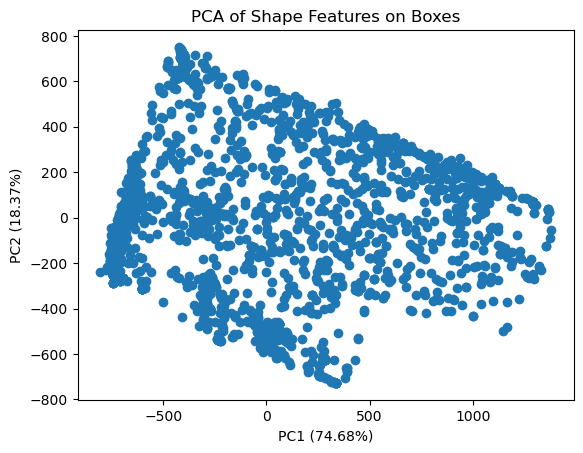

: 

In [46]:
num_samples, num_features = outputs_array.shape[0], np.prod(outputs_array.shape[1:])
outputs_array_reshaped = outputs_array.reshape(num_samples, num_features)
pca = PCA(n_components=2)  # Set the number of components as desired
pca_result = pca.fit_transform(outputs_array_reshaped)
pca_components = pca.components_
explained_variance_ratios = pca.explained_variance_ratio_

# Print the PCA results
print("PCA Components:")
print(pca_components)
print("Explained Variance Ratios:")
print(explained_variance_ratios)

# Plot the PCA results
plt.scatter(pca_result[:, 0], pca_result[:, 1])
# Label axes with variance ratios
plt.xlabel(f"PC1 ({explained_variance_ratios[0] * 100:.2f}%)")
plt.ylabel(f"PC2 ({explained_variance_ratios[1] * 100:.2f}%)")
plt.title("PCA of Shape Features on Boxes")
plt.show()
    

In [44]:
ix2box = {}
ix2timestamp = {}
timestamp2ix = {}

for ix, item in enumerate(shape_loader):
    box = Box(
        id=item["id"][0],
        left=item["left"][0],
        top=item["top"][0],
        width=item["width"][0],
        height=item["height"][0],
    )
    ix2box[ix] = box
    ix2timestamp[ix] = item["timestamp"][0]
    timestamp2ix[item["timestamp"][0]] = ix

In [24]:
class Labeller:
    def __init__(self, color_dir, distance_threshold=150, give_up_after=10, min_num_label=10):
        self.color_dir = color_dir
        self.distance_threshold = distance_threshold
        self.give_up_after = give_up_after
        self.min_num_label = min_num_label
        self.labelled: dict[int, str] = {}
        self.candidate_ix = -1
        self.used_labels = ["Garbage"]
        self.entry_ix = 0
        self.get_new_candidate()
        self.image_elem = sg.Image(data=Labeller.get_image_data(self.get_candidate_file(), first=True))
        self.label_col = [
            [sg.Listbox(values=self.used_labels, enable_events=True, size=(20, 10), font=('Arial Bold', 20), key='listbox')],
            [sg.Input('', enable_events=True, key='new_label', font=('Arial Bold', 20), expand_x=True, justification='left')],
            [sg.Button('Select', size=(8, 2))]
        ]
        self.image_col = [[self.image_elem]]
        layout = [[sg.Column(self.label_col), sg.Column(self.image_col)]]
        self.window = sg.Window(
            'Labeller',
            layout,
            return_keyboard_events=True,
            location=(0, 0),
            use_default_focus=False,
            size=(1200, 850),
        )
    
    def get_candidate_file(self):
        box = ix2box[self.candidate_ix]
        timestamp = ix2timestamp[self.candidate_ix]
        return f"{self.color_dir}/{timestamp}_{box.id}.jpg"
    
    def run(self):
        while True:
            data = self.window.read()
            if data == None:
                continue
            event, values = data
            # perform button and keyboard operations
            if event == sg.WIN_CLOSED:
                break
            elif event == 'Select':
                if len(values['listbox']) == 0 and len(values['new_label']) == 0:
                    continue
                elif len(values['new_label']) > 0:
                    label = values['new_label']
                else:
                    label = values['listbox'][0]
                self.labelled[self.entry_ix] = label
                found = self.get_new_candidate()
                if not found and len(self.labelled) >= self.min_num_label:
                    break
                self.image_elem.update(data=Labeller.get_image_data(self.get_candidate_file()))
                if label not in self.used_labels:
                    self.used_labels.append(label)
                    self.window['listbox'].update(values=self.used_labels)
        self.window.close_destroys_window = True
        self.window.close()

    def get_new_candidate(self) -> bool:
        for count in range(self.give_up_after):
            self.entry_ix += 1
            too_close = False
            for other_ix in self.labelled.keys():
                    this_pca = pca_result[self.entry_ix]
                    other_pca = pca_result[other_ix]
                    distance = np.linalg.norm(this_pca - other_pca)
                    if distance < self.distance_threshold:
                        too_close = True
                        break
            if too_close:
                continue
            self.candidate_ix = self.entry_ix
            return True
        return False


    @staticmethod
    def get_image_data(filename, maxsize=(1200, 850), first=False):
        pil_image = Image.open(filename)
        pil_image.thumbnail(maxsize)
        if first:
            bio = io.BytesIO()
            pil_image.save(bio, format="PNG")
            del pil_image
            return bio.getvalue()
        return ImageTk.PhotoImage(pil_image)


In [25]:
labeller = Labeller("jankos/boxes/color", distance_threshold=125, give_up_after=15, min_num_label=15)
labeller.run()

Text(0.5, 1.0, 'Points Chosen for User Feedback')

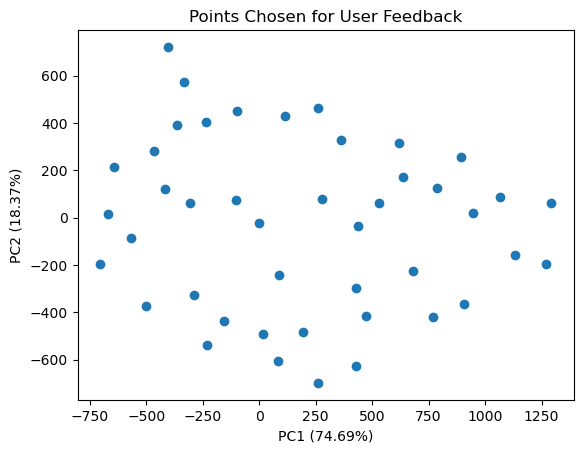

In [40]:
ixs = list(labeller.labelled.keys())
labels = [labeller.labelled[ix] for ix in ixs]
plt.scatter(pca_result[ixs, 0], pca_result[ixs, 1])
plt.xlabel(f"PC1 ({explained_variance_ratios[0] * 100:.2f}%)")
plt.ylabel(f"PC2 ({explained_variance_ratios[1] * 100:.2f}%)")
plt.title("Points Chosen for User Feedback")

## Update

I'm happy with how the labeller turned out. Right now, I'm going to simply just fill in the rest of the points by picking the closest labelled thing, but eventually I would want to do some kind of guided clustering.

Once I have this then I can actually write the pipeline that constructs the text as the video goes on, implement a little GUI to search, and voila.

In [36]:
label2ixs = {}
ix2label = {}

final_labels = []
for ix in range(len(pca_result)):
    result = ""

    if ix in labeller.labelled:
        result = labeller.labelled[ix]
        final_labels.append(labeller.labelled[ix])
    else:
        # Find the closest label
        min_distance = np.inf
        min_label = None
        for labelled_ix in labeller.labelled.keys():
            this_pca = pca_result[ix]
            other_pca = pca_result[labelled_ix]
            distance = np.linalg.norm(this_pca - other_pca)
            if distance < min_distance:
                min_distance = distance
                min_label = labeller.labelled[labelled_ix]
        result = min_label
    
    if result not in label2ixs:
        label2ixs[result] = []
    label2ixs[result].append(ix)
    ix2label[ix] = result
    final_labels.append(result)

Text(0.5, 1.0, 'Extrapolation After User Feedback')

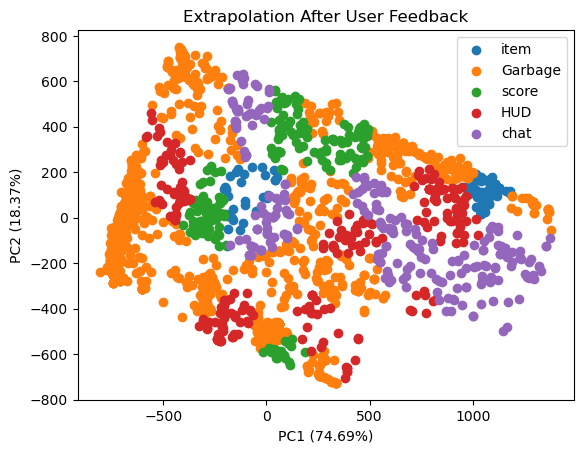

In [41]:
# Scatter plot for label2ixs
for label, ixs in label2ixs.items():
    plt.scatter(pca_result[ixs, 0], pca_result[ixs, 1], label=label)
plt.legend()
plt.xlabel(f"PC1 ({explained_variance_ratios[0] * 100:.2f}%)")
plt.ylabel(f"PC2 ({explained_variance_ratios[1] * 100:.2f}%)")
plt.title("Extrapolation After User Feedback")